<a href="https://colab.research.google.com/gist/ElanaPearl/444b3331f61485bbe8862db27cb2b968/mapping-chemical-space-with-umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021 Reverie Labs. All rights reserved. This work is licensed under the terms of the [MIT license](https://opensource.org/licenses/MIT).

# Mapping Chemical Space with 2D vusualization

This script show embed smiles dataset as [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t)



# Imports & Utils

In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
%%bash
# Install UMAP/hdbscan (recommend to do this before miniconda)
pip install --quiet umap-learn hdbscan

# Install miniconda
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.9.2-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget -q https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX > /dev/null

# Install rdkit (should only be installed via conda)
conda install -y --quiet -c conda-forge rdkit=2020.09.2 > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [ ]:
!pip install pip --upgrade
!pip install pyopenssl --upgrade

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

In [ ]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [ ]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

# Embed BBBP with UMAP, PCA, t-SNE (Dataset-Specific Embeddings)

### Read in and process data

In [ ]:
#Modification


Pre_Dataset = pd.read_csv("./reference.txt", sep = "\t", header = None)
Pre = pd.read_csv("./Transformer_Encoder_FFNN_ref10.csv", header = None)
Fine_Dataset = pd.read_csv("./latent_covid.csv", header = None)
Fine = pd.read_csv("./Transformer_FINETUNING_filtered.csv", header = None)



Pre_Dataset.columns = ["smiles"]
Pre.columns = ["smiles"]

Fine_Dataset.columns = ["smiles"]
Fine.columns = ["smiles"]


Pre = pd.DataFrame(Pre.loc[0:10000, "smiles"])


In [ ]:
Pre_Dataset.head()

In [ ]:
Pre_Dataset = Pre_Dataset.sample(1000, random_state = 1004)

Pre_Dataset

In [ ]:
Pre = Pre.sample(1000, random_state = 1004)
Pre

In [ ]:
Fine

In [ ]:


Pre_Dataset["Transfer_Learning"] = "Pre-Training_Dataset"
Pre_Dataset["Index"] = Pre_Dataset.index.values

Pre["Transfer_Learning"] = "Pre-Training"
Pre["Index"] = Pre.index.values

Fine_Dataset["Transfer_Learning"] = "Fine-Tuning_Dataset"
Fine_Dataset["Index"] = Fine_Dataset.index.values

Fine["Transfer_Learning"] = "Fine-Tuning"
Fine["Index"] = Fine.index.values

In [ ]:
Concat_Pre_Fine = pd.concat([Fine_Dataset], axis = 0)

Concat_Pre_Fine

### Compute ECFP Descriptors

#### Load Calculated ECFP Results

In [ ]:
!ls ../Results/CSV

'chembl_sample_Global Chemical Space Embedding.csv'
 Fine-Tuning_Dataset_Fine.csv
 Pre-Training_Fine-Tuning.csv
 Pre-Tuning_Dataset_Pre.csv
'test_sample_Dataset-Agnostic Embedding of Fine-Tuning Results.csv'


In [ ]:
Candidate = pd.read_csv('../Results/CSV/Fine-Tuning_Dataset_Fine.csv')

Candidate

,smiles,Transfer_Learning,Index,UMAP_1,UMAP_2,PCA_1,PCA_2,TNSE_1,TNSE_2
0,c1cc(ccc1C(F)(F)F)S(=O)(=O)N2CCN(C[C@@H]2C(=O)...,Fine-Tuning_Dataset,0,-0.374148,-1.542436,0.037561,0.170262,43.024384,-14.120255
1,C1N(c2nc3nc(C4CC4)ncc3s2)C[C@H](C(NCc2ccc(OC(F...,Fine-Tuning_Dataset,1,-0.366813,-1.535265,0.037561,0.170262,42.518800,-13.799914
2,O=S(c1ccc(C(F)(F)F)cc1)(=O)N1[C@@H](C(NCc2cc(F...,Fine-Tuning_Dataset,2,-0.378878,-1.546088,0.037561,0.170262,43.024384,-14.120255
3,C1CN(c2nc3nc(C4CC4)ncc3s2)C[C@H](C(=O)NCc2ccc(...,Fine-Tuning_Dataset,3,-0.373883,-1.541702,0.037561,0.170262,42.518800,-13.799914
4,C1[C@H](C(=O)NCc2ccc(OC(F)(F)F)c(F)c2)N(S(c2cc...,Fine-Tuning_Dataset,4,-0.374184,-1.542127,0.037561,0.170262,43.024384,-14.120255
...,...,...,...,...,...,...,...,...,...
1584,C1CCCCC1N(Cc1c(C2CCC2)cc(CC2CC2)nc1)c1ccccc1,Fine-Tuning,1085,-2.674360,-2.664521,0.415172,0.448690,14.565248,-0.141856
1585,C1C(C2=C(C(=O)NC)C3(CCCCC3)CCC2(C)CN)C=C1,Fine-Tuning,1086,-3.769183,-2.611828,0.646037,1.021644,7.669234,-10.190352
1586,O=C(NC(C(F)(F)F)C(F)(F)F)CCC(=O)N1CCNCC1,Fine-Tuning,1087,-7.822628,-3.465831,0.191654,0.310545,4.969465,-23.246977
1587,s1c(-c2c(N3CCC5CCCCC5(C)C3)cccc2)ccc1Cl,Fine-Tuning,1088,-3.117910,-3.259626,-0.427667,0.324283,22.951752,7.115162


In [ ]:
Candidate['T-SNE_1'] = Candidate['TNSE_1']
Candidate['T-SNE_2'] = Candidate['TNSE_2']

In [ ]:
hue_parameter = "Transfer_Learning"

#### Caculate ECFP

In [ ]:
Candidate = Concat_Pre_Fine


In [ ]:
hue_parameter = "Transfer_Learning"

In [ ]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(Candidate["smiles"])

# Only keep those that sucessfully featurized
Candidate = Candidate.iloc[keep_idx]

### Embed with UMAP

In [ ]:
%%time
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(ecfp_descriptors)
Candidate["UMAP_1"], Candidate["UMAP_2"] = X_umap[:,0], X_umap[:,1]

/usr/local/lib/python3.9/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 23.5 s, sys: 214 ms, total: 23.8 s
Wall time: 23.2 s


### Embed with PCA

In [ ]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
Candidate["PCA_1"], Candidate["PCA_2"] = X_pca[:,0], X_pca[:,1]

CPU times: user 283 ms, sys: 199 ms, total: 482 ms
Wall time: 257 ms


### Embed with t-SNE

In [ ]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
Candidate["TNSE_1"], Candidate["TNSE_2"] = X_tsne[:,0], X_tsne[:,1]

CPU times: user 25.3 s, sys: 477 ms, total: 25.8 s
Wall time: 17.7 s


### Visualize the dataset embeddedings

In [ ]:
palette = []

palette.extend(sns.color_palette("Accent", 6))

palette

[(0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (1.0, 1.0, 0.6),
 (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745)]

In [ ]:
palette_1 = [] 
palette_1.append(palette[0])
palette_1.append(palette[1])

palette_1

[(0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079)]

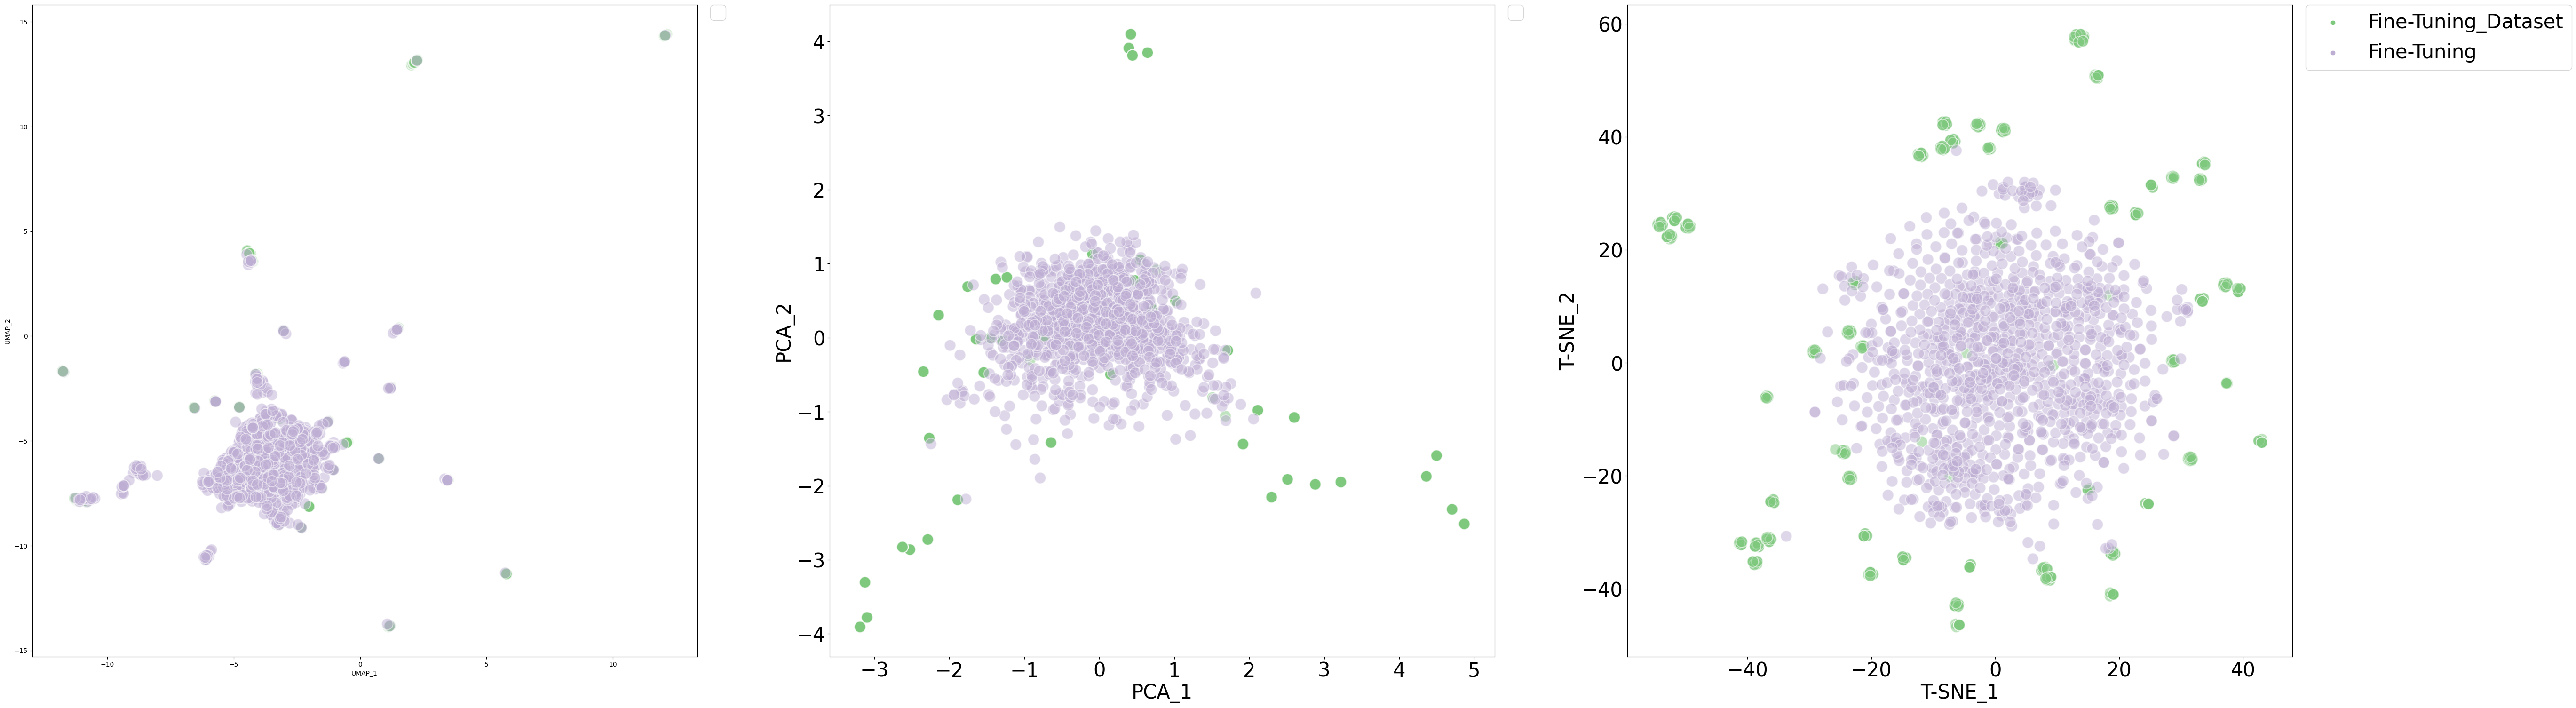

In [ ]:

plt.figure(figsize=(62,18))

for method in ["UMAP", "PCA", "T-SNE"]: # 
 
    if (method == "UMAP"):
          plt.subplot(131)
    elif (method == "PCA"):
          plt.subplot(132)
    elif (method == "T-SNE"):
          plt.subplot(133)

    if (method == 'T-SNE'):
      sns.scatterplot(data=Candidate,
                    x=f"{method}_1",
                    y=f"{method}_2",
                    hue = hue_parameter,
                    alpha = 0.5,
                    palette = palette_1,
                    s = 300)
    else:
       sns.scatterplot(data= Candidate,
                    x=f"{method}_1",
                    y=f"{method}_2",
                    hue = hue_parameter,
                    alpha = 0.5,
                    palette = palette_1,
                    s = 300,
                    legend=False)
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 30)        
    

    plt.rc('font', size=30)        # 기본 폰트 크기
    plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기


plt.show()